In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/TUM_RGBD/freiburg2_coke.yaml'])
cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

INFO: The output folder is output/TUM_RGBD/rgbd_dataset_freiburg2_coke
INFO: The GT, generated and residual depth/color images can be found under output/TUM_RGBD/rgbd_dataset_freiburg2_coke/mapping_vis/
INFO: The mesh can be found under output/TUM_RGBD/rgbd_dataset_freiburg2_coke/mesh/
INFO: The checkpoint can be found under output/TUM_RGBD/rgbd_dataset_freiburg2_coke/ckpt/


tensor([[ 1., -0., -0.,  0.],
        [ 0., -1., -0.,  0.],
        [ 0., -0., -1.,  0.],
        [ 0.,  0.,  0.,  1.]])

In [8]:
class Segmenter(object):

    def __init__(self, slam, cfg, args, zero_pos, store_directory):
        self.store_directory = store_directory
        self.zero_pos = zero_pos
        os.makedirs(f"{store_directory}", exist_ok=True)

        self.is_full_slam = cfg["Segmenter"]["full_slam"]
        self.store_vis = cfg["Segmenter"]["store_vis"]
        self.use_stored = cfg["Segmenter"]["use_stored"]
        self.first_min_area = cfg["mapping"]["first_min_area"]

        """path_to_traj = cfg["data"]["input_folder"] + "/traj.txt"
        self.T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
        self.T_wc[:, 1:3] *= -1"""

        self.every_frame = cfg["mapping"]["every_frame"]
        # self.slam = slam
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        #self.estimate_c2w_list = slam.estimate_c2w_list
        s = np.ones((4, 4), int)
        s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        self.shift = s  # s
        # self.idx_coarse_mapper = slam.idx_coarse_mapper

        self.every_frame_seg = cfg["Segmenter"]["every_frame"]
        self.points_per_instance = cfg["mapping"]["points_per_instance"]
        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )
        self.K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
        if args is None or args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder
        self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        # self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        self.frame_reader = get_dataset(
            cfg,
            args,
            cfg["scale"],
            device=cfg["mapping"]["device"],
            tracker=True,
            slam=slam,
        )
        self.estimate_c2w_list = np.concatenate([p[None] for p in self.frame_reader.poses], axis=0)
        print(self.estimate_c2w_list.shape)
        print(f'est list: {self.estimate_c2w_list[0]}')
        self.n_img = self.frame_reader.n_img
        self.semantic_frames = slam.semantic_frames
        self.idx_segmenter = slam.idx_segmenter
        if not self.is_full_slam:
            self.idx = torch.tensor([self.n_img])
        else:
            self.idx = slam.idx  # Tracking index
            # Segmenter index
        # self.new_id = 0
        self.visualizer = vis.visualizerForIds()
        self.frame_numbers = []
        self.samples = None
        self.deleted = {}
        self.border = (
            cfg["cam"]["crop_edge"]
            if "crop_edge" in cfg["cam"]
            else cfg["Segmenter"]["border"]
        )
        self.num_clusters = cfg["Segmenter"]["num_clusters"]
        self.overlap = cfg["Segmenter"]["overlap"]
        self.relevant = cfg["Segmenter"]["relevant"]
        self.max_id = 0
        self.update = {}
        self.verbose = cfg["Segmenter"]["verbose"]
        self.merging_parameter = cfg["Segmenter"]["merging_parameter"]
        self.hit_percent = cfg["Segmenter"]["hit_percent"]


    def segment_idx_forAuto(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        img = (img.cpu().numpy() * 255).astype(np.uint8)
        masksCreated, s, max_id = id_generation.createFrontMappingAutosort(
            idx,
            self.estimate_c2w_list * self.shift,
            self.K,
            depth.cpu(),
            self.predictor,
            max_id=self.max_id,
            current_frame=img,
            samples=self.samples,
            smallesMaskSize=1000,
            border=self.border,
        )

        self.samples = s
        self.max_id = max_id

        frame = torch.from_numpy(masksCreated)
        self.semantic_frames[idx // self.every_frame_seg] = frame
        return frame

    def segment_first_ForAuto(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam_forauto("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = backproject.generateIds_Auto(masks, min_area=self.first_min_area)
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        ids[depth.cpu() == 0] = -100
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max() + 1
        
        samplesFromCurrent = backproject.sample_from_instances_with_ids_area(
            ids, self.max_id, points_per_instance=500
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.zero_pos*self.shift,
            self.K,
            depth.cpu(),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return realWorldSamples

    def runAuto(self, max=-1):
        visualizerForId = vis.visualizerForIds()

        print("segment first frame")
        s = self.segment_first_ForAuto()
        #print("finished segmenting first frame")
        im = visualizerForId.visualize(self.semantic_frames[0])
        plt.show()
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        self.samples = s
        self.predictor = create_instance_seg.create_sam_forauto("cuda")
   
        index_frames = np.arange(
            self.every_frame_seg, self.n_img, self.every_frame_seg
        )
          
        
        for idx in index_frames: #tqdm(index_frames, desc="Segmenting frames"):
            #print("start segmenting frame: ", idx)
            self.segment_idx_forAuto(idx)
            #print("finished segmenting frame: ", idx)
            im = visualizerForId.visualize(
                self.semantic_frames[idx // self.every_frame_seg]
            )
            plt.show()
            _,depth= frame_reader.get_colorAndDepth(idx)
            sns.heatmap(depth.cpu().numpy() == 0)
            plt.show()
            # self.plot()
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            _ = self.segment_idx_forAuto(self.n_img - 1)


        return self.semantic_frames, self.max_id + 1
    
    def plot(self):
        data = self.samples.copy()
        data = data[:, data[1] > -2]
        data = self.samples.copy()
        data = data[:, data[1] > -2]
        x = data[0]
        y = data[1]
        z = data[2] * -1
        z = data[2] * -1
        labels = data[3]

        # Create a scatter plot
        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d")
        ax = fig.add_subplot(111, projection="3d")

        # Plot each point with a color corresponding to its label
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)
            ax.scatter(x[indices], y[indices], z[indices], s=3)

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_ylim((-2, 2))
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_ylim((-2, 2))
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()



In [9]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

(2415, 4, 4)
est list: [[ 1. -0. -0.  0.]
 [ 0. -1. -0.  0.]
 [ 0. -0. -1.  0.]
 [ 0.  0.  0.  1.]]


segment first frame


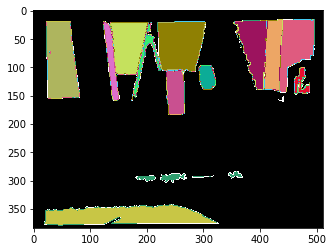

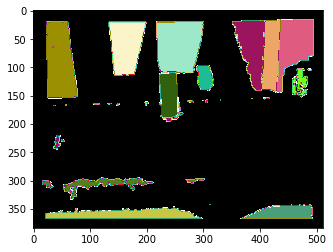

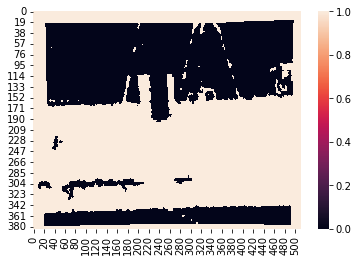

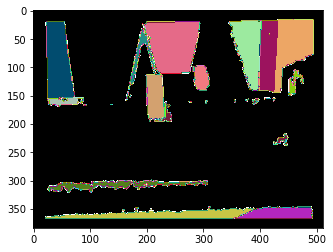

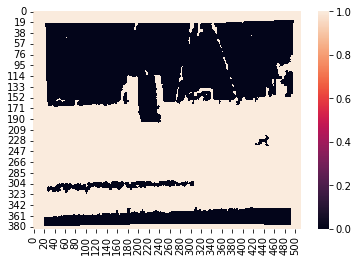

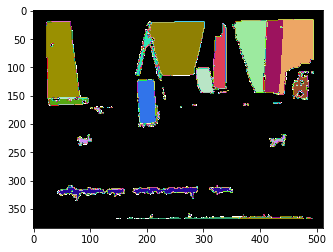

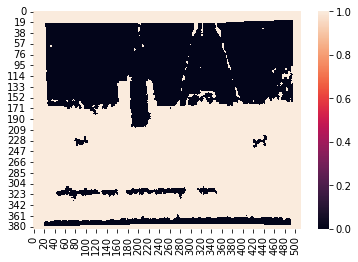

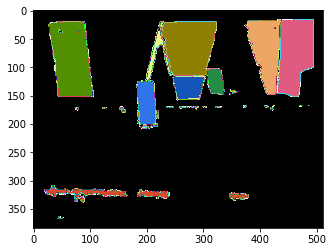

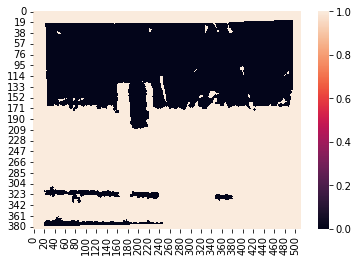

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [5]:
segmenter.runAuto()

In [9]:
frame_reader.n_img//50

48

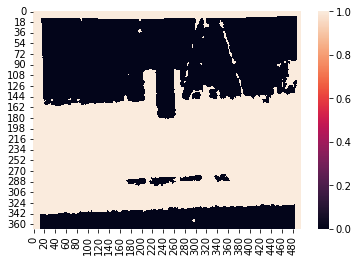

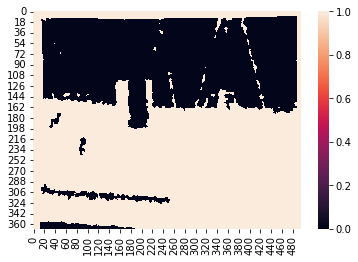

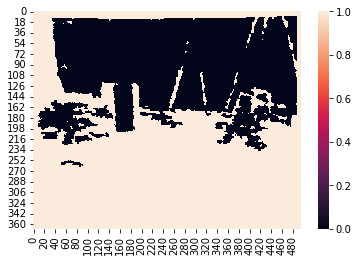

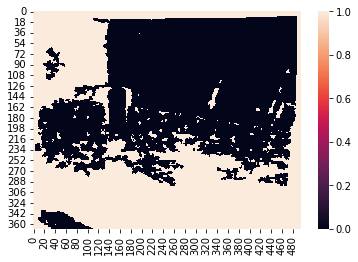

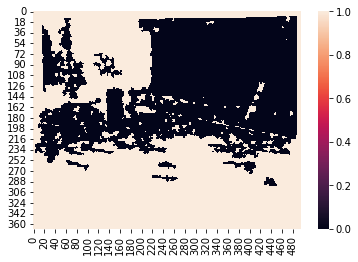

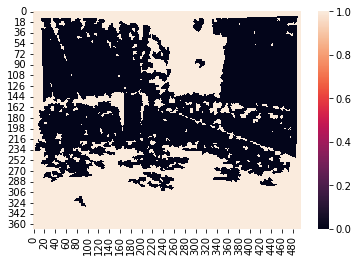

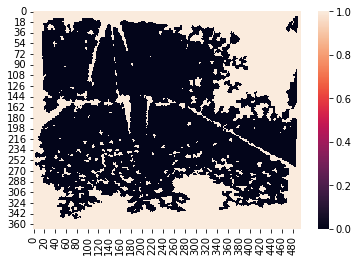

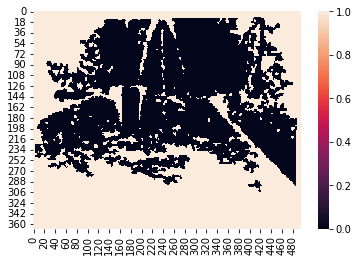

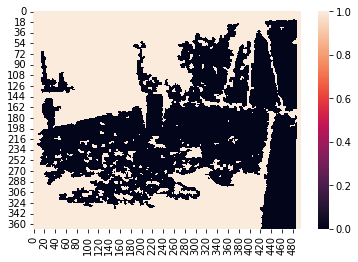

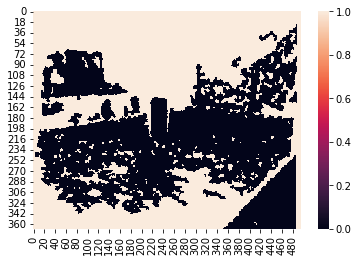

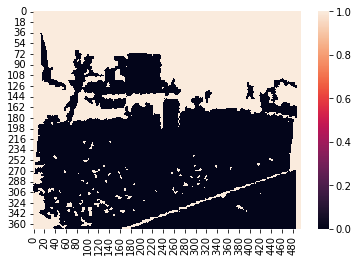

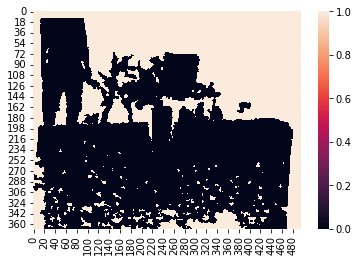

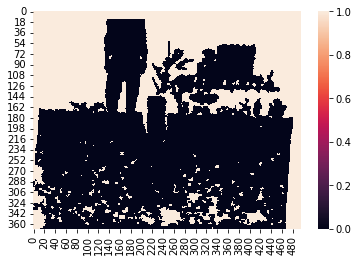

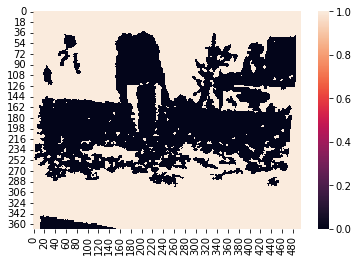

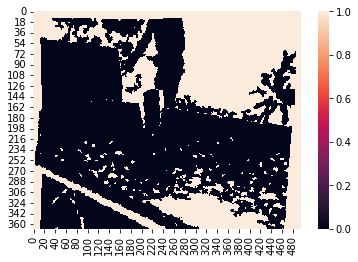

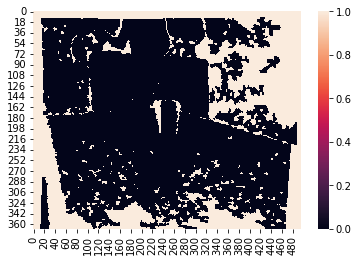

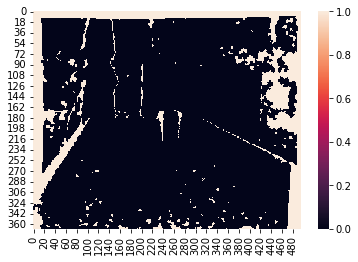

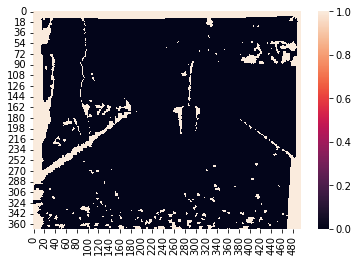

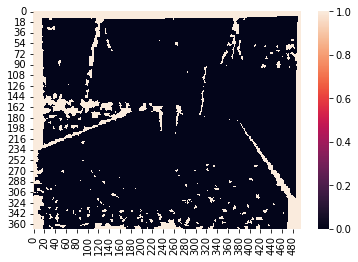

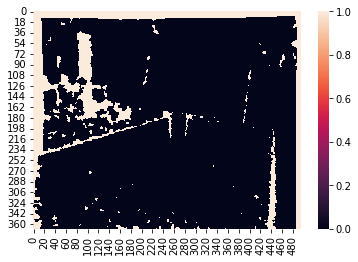

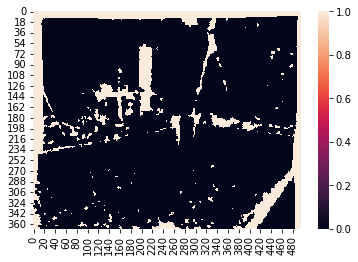

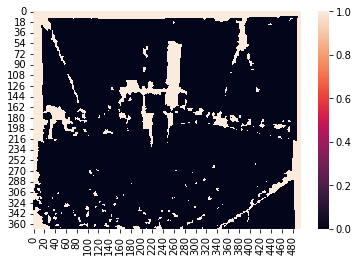

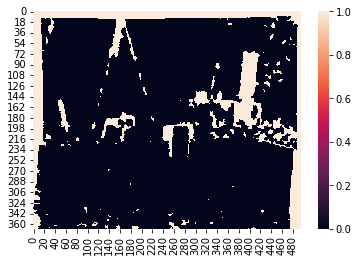

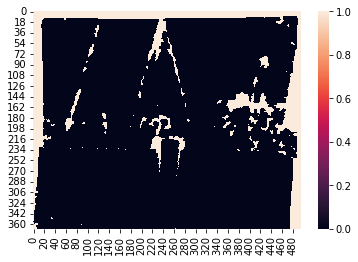

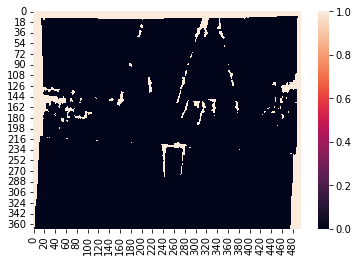

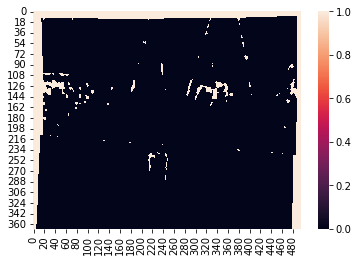

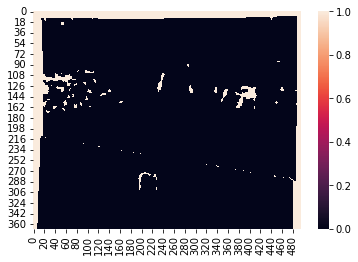

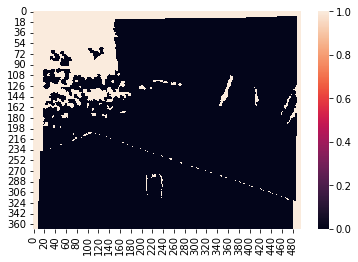

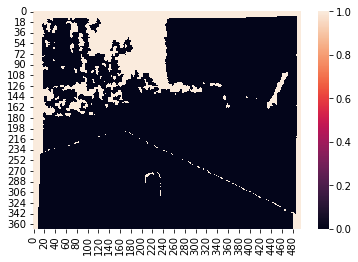

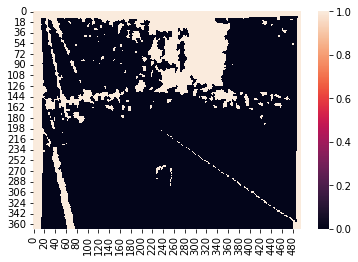

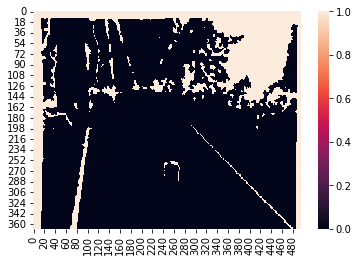

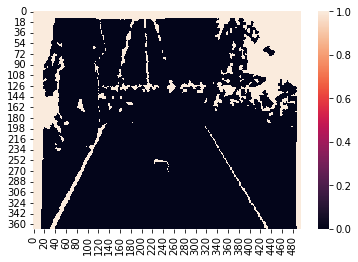

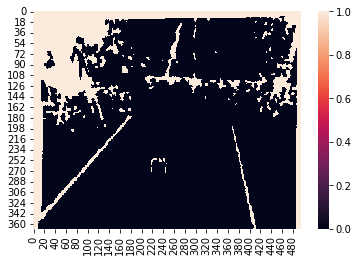

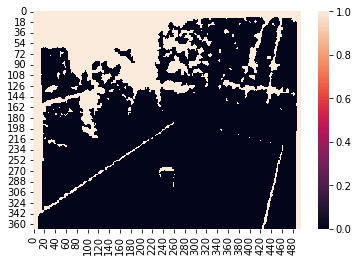

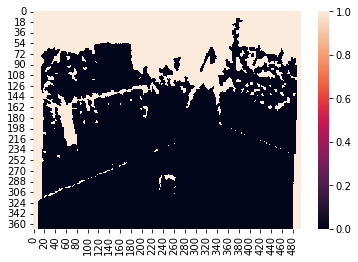

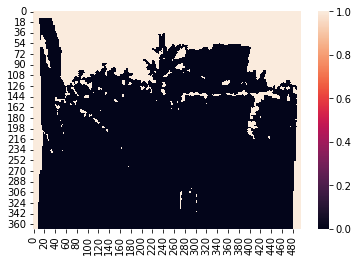

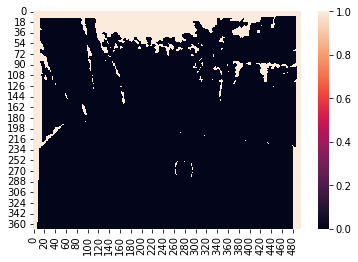

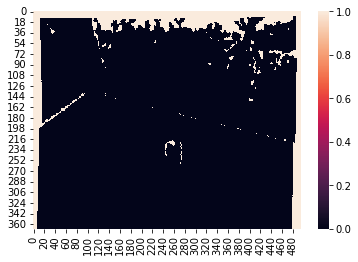

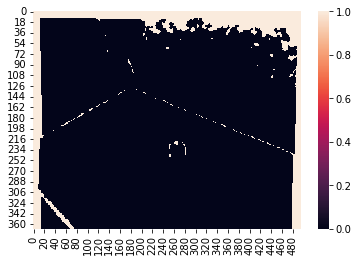

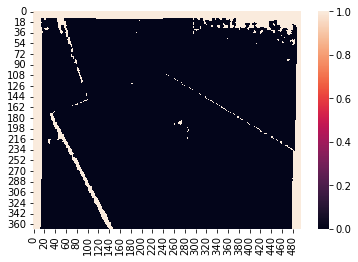

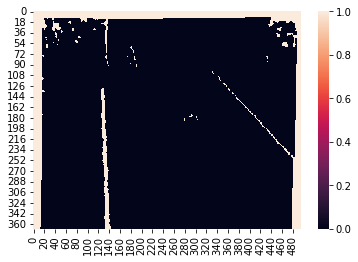

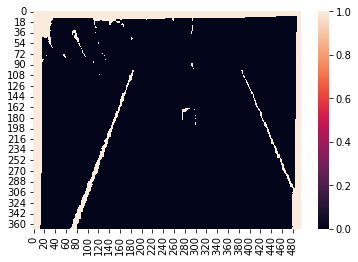

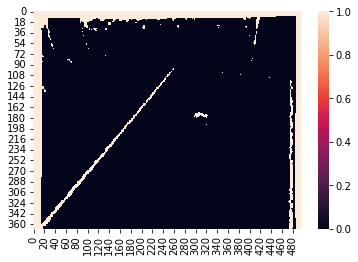

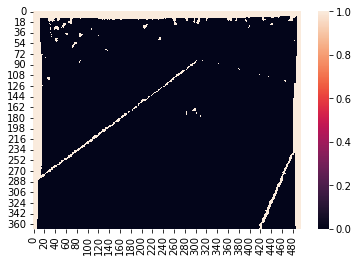

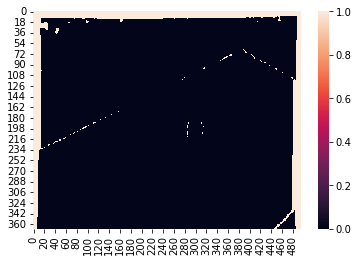

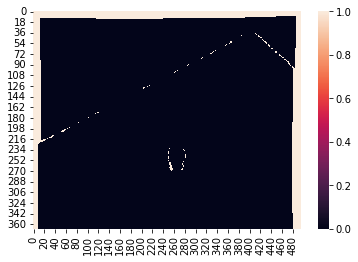

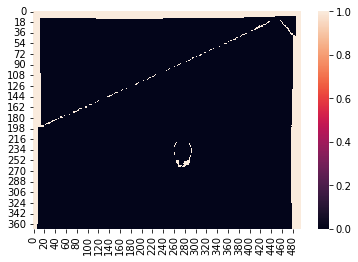

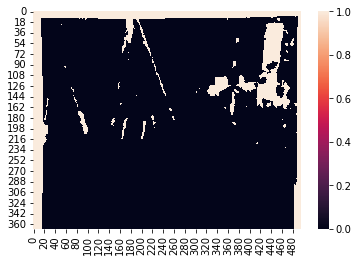

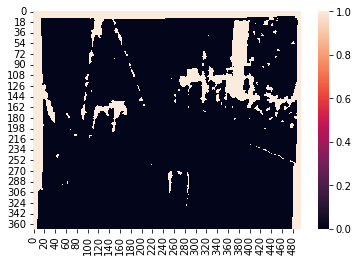

<Figure size 432x288 with 0 Axes>

In [10]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()
